In [288]:
%pylab inline
pylab.rcParams["figure.figsize"] = (15,5)

import scipy.signal
import scipy.io.wavfile

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [289]:
from rtlsdr import RtlSdr

In [311]:
Fcarrier = 104.5e6
Foffset = 128e3
Fc = Fcarrier+Foffset # Center frequency
Fs = 1024000          # Sample rate

N = int(2 * Fs) # Pull in this many samples
gain = 0.9     # Gain

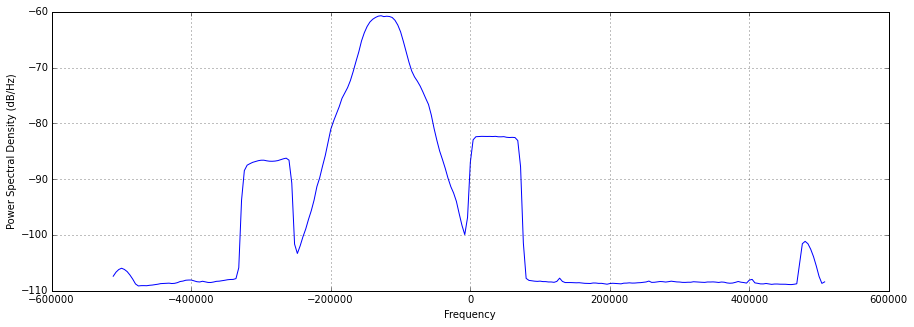

In [312]:
sdr = RtlSdr()
# configure device
sdr.sample_rate = int(Fs) # Hz
sdr.center_freq = int(Fc) # Hz
sdr.gain = gain

# Read samples
samples = sdr.read_samples(N)
sdr.close()
del(sdr)

psd(samples, Fs=Fs); None

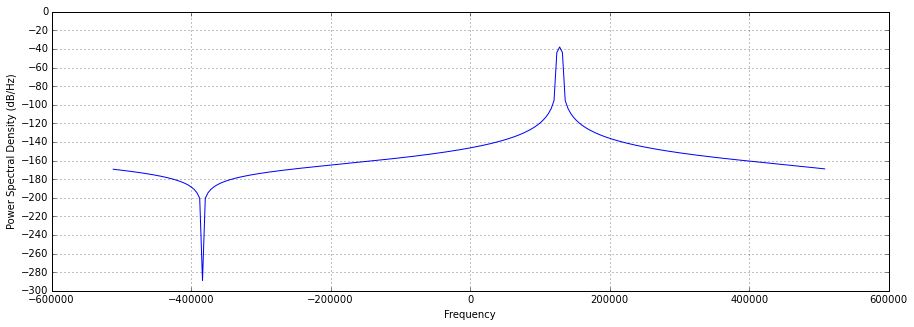

In [313]:
phase_vel = (2*np.pi*Foffset)/Fs
t = np.arange(0, len(samples), 1.0)
x_offset = np.exp(1.0j*t*phase_vel) # np.cos(t*phase_vel) + 1.0j * np.sin(t*phase_vel)
psd(x_offset, Fs=Fs); None

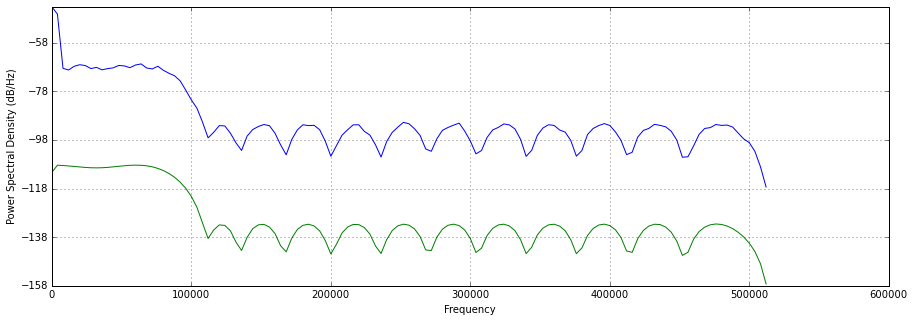

In [323]:
lpf_coeffs = scipy.signal.remez(30, [0, 75000, 75000+Fs/32, Fs/2], [1,0], Hz=Fs)
noise = np.random.uniform(size=10000)

lpf_response = scipy.signal.lfilter(lpf_coeffs, 1.0, noise) # [1.0] + [0.0]*10000)
lpf_response2 = scipy.signal.lfilter(lpf_coeffs, 1.0, [0.0] * 100000 + [1.0] + [0.0]*100000)

psd(lpf_response, Fs=Fs); None
psd(lpf_response2, Fs=Fs); None

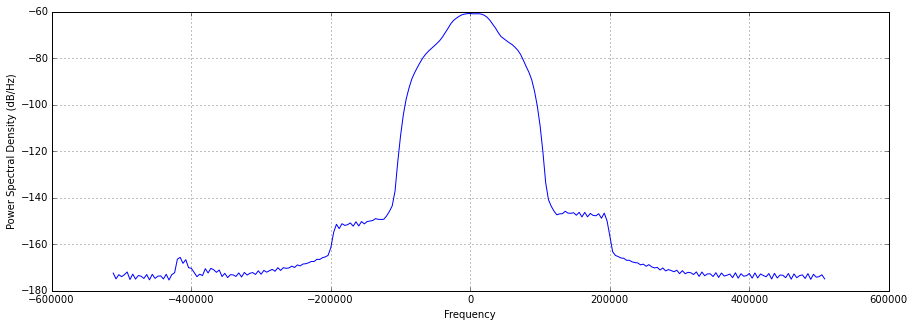

In [316]:
samples_shifted = samples * x_offset
x = scipy.signal.lfilter(lpf_coeffs, 1.0, samples_shifted)
psd(x, Fs=Fs); None

In [317]:
def demod_pm(x, gain=1.0):
    xp = x[1:] * np.conj(x[:-1]) 
    retval = gain * np.arctan2(np.imag(xp), np.real(xp))
    return retval

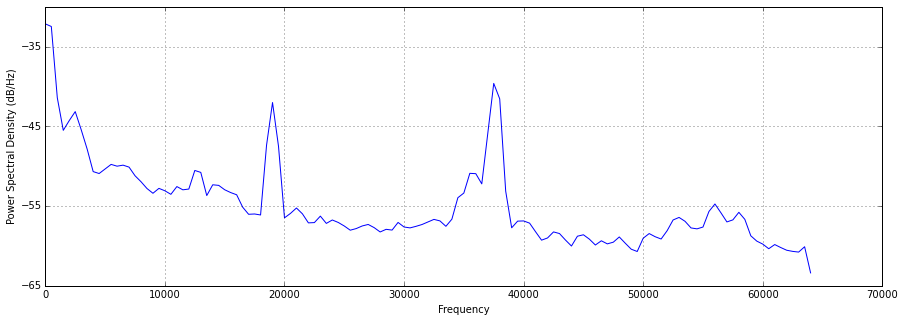

In [318]:
audio_decim = 8
Faudio = Fs/audio_decim

audio = demod_pm(x[::audio_decim])

psd(audio, Fs=Faudio); None

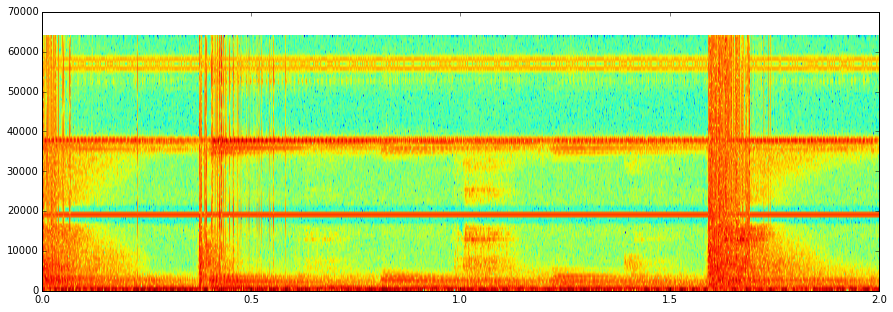

In [319]:
specgram(audio, Fs=Faudio); None

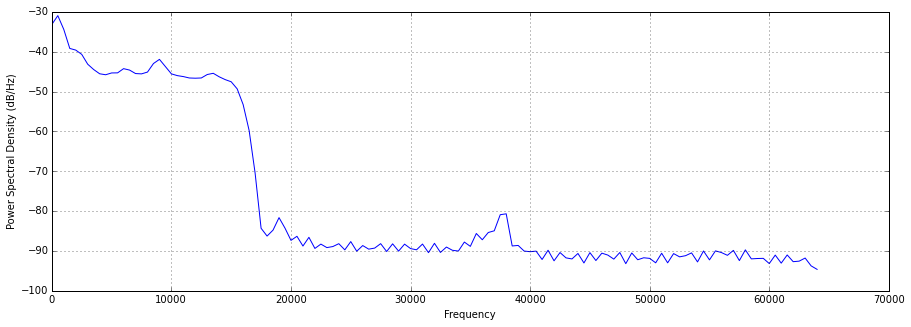

In [299]:
lpf_audio_coeffs = scipy.signal.remez(111, [0, 15000, 17000, Faudio/2], [1,0], Hz=Faudio)
audio_lpf = scipy.signal.lfilter(lpf_audio_coeffs, 1.0, audio)
psd(audio_lpf, Fs=Faudio); None

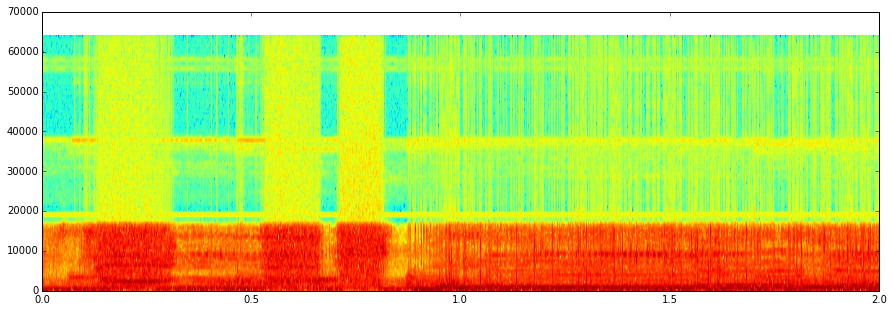

In [300]:
specgram(audio_lpf, Fs=Faudio); None

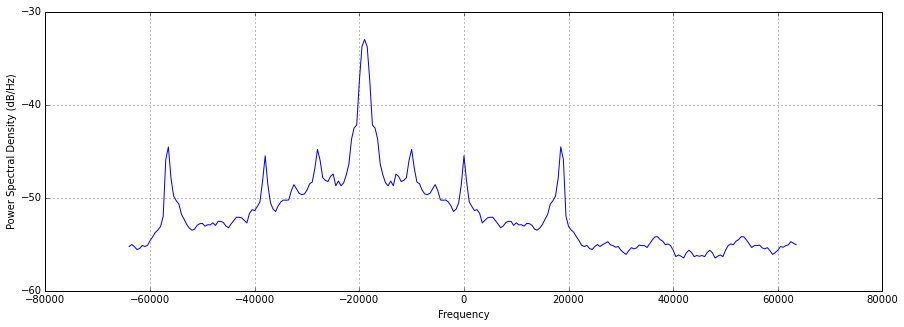

In [301]:
bar = audio * np.exp(1.0j * -2*np.pi*38000/2/Faudio*np.arange(0, len(audio)))
psd(bar, Fs=Faudio); None
#xlim(0,75000)

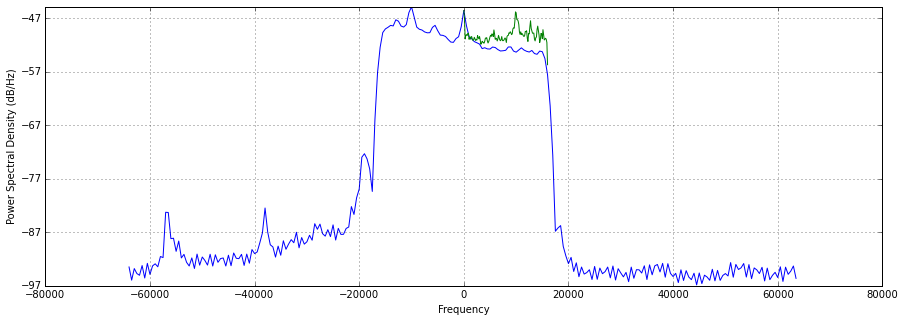

In [302]:
baz = scipy.signal.lfilter(lpf_audio_coeffs, 1.0, bar)
psd(baz, Fs=Faudio); None

stereo_decim = 4
Fstereo = Faudio/stereo_decim

baz_lmr = np.real(baz[::stereo_decim])
psd(baz_lmr, Fs=Fstereo); None

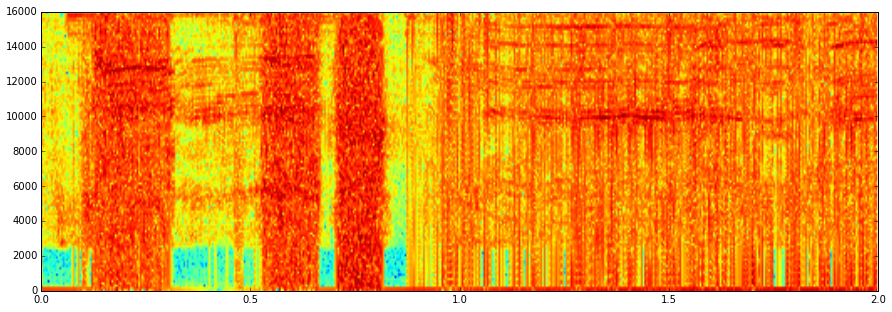

In [303]:
specgram(baz_lmr, Fs=Fstereo); None

In [304]:
stereo_am = np.real(baz_lmr)

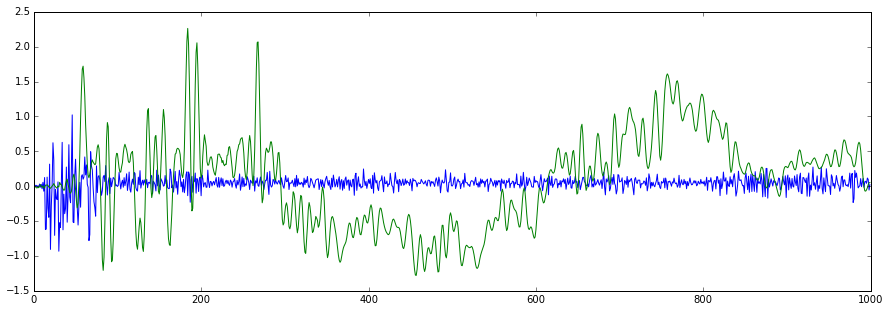

In [305]:
plot(stereo_am[0:1000])
plot(audio_lpf[0:1000])

In [306]:
audio_lpr = audio_lpf[0:(stereo_decim*len(stereo_am)-1):(stereo_decim)]
audio_l = (audio_lpr + stereo_am) / 40
audio_r = (audio_lpr - stereo_am) / 40

full_stereo = np.array([audio_l, audio_r]).T

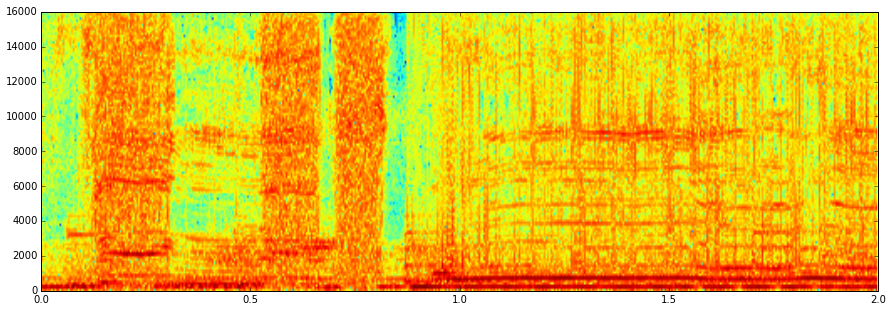

In [307]:
specgram(audio_lpr, Fs=Fstereo); None
#axhline(38000)

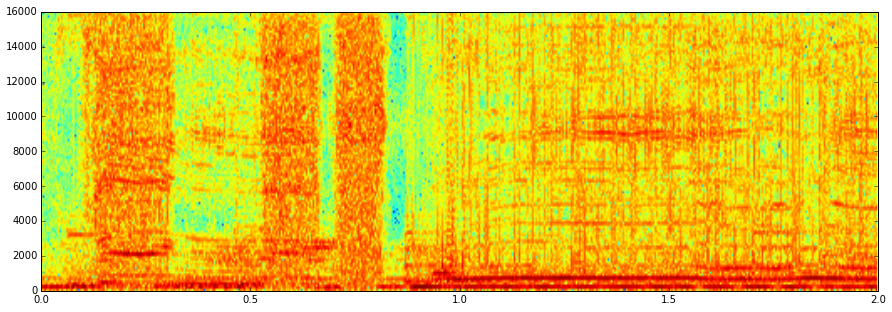

In [308]:
specgram(audio_l, Fs=Fstereo); None

In [309]:
scipy.io.wavfile.write("fm_raw.wav", Fstereo, audio_lpr)
scipy.io.wavfile.write("am_only.wav", Fstereo, np.abs(stereo_am))
scipy.io.wavfile.write("am.wav", Fstereo, full_stereo)

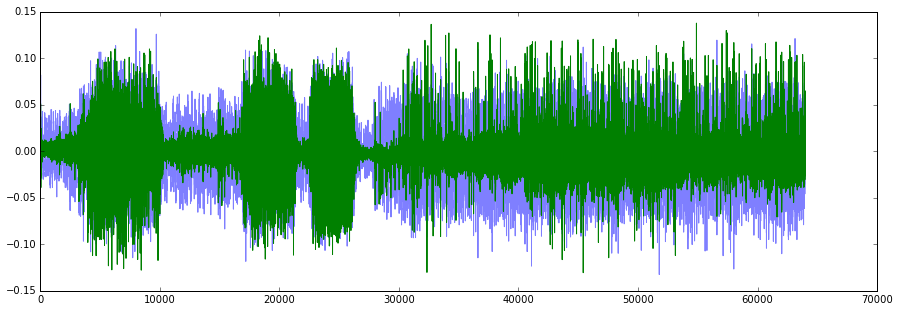

In [310]:
plot(audio_l, alpha=0.5)
plot(audio_l - audio_r)
